In [111]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

rc('text', usetex=True)
plt.rcParams['figure.figsize'] = (12, 8)

## Sensitivity to ETI RADAR

If we would like to determine the sensitivity to a ETI RADAR system we have to consider the intensity of, and distance to the ETI signal, and the sensitivity of our radio telescopes. We need to answer the following:

1. What is the flux density of a RADAR or any broadband, short duration in time pulse from a distance source, such as an ETI?
2. How sensitive would we be to such a signal with the current and future radio telescopes?

We will use the Arecibo RADAR system as a proxy for an ETI RADAR system. The Arecibo S-band (12.6 cm, 2380 MHz) RADAR system ([1](http://www.naic.edu/~nolan/radar/),[2](http://www.naic.edu/~astro/RXstatus/Sradar/Sradar.shtml)) is a highly-directive, long-distance signal marker. The RADAR system has the following specifications:

| S-Band RADAR  |               |
| -------------:| ------------- |
| Transmission Frequency | 2380 MHz |
| Bandwidth     | 100 MHz       |
| Polarization  | Dual Circular |
| Power         | 900 kW ([3](https://arxiv.org/pdf/1604.01080.pdf)) |
| Analogue Gain | 10 K/Jy ([4](http://www.naic.edu/~phil/pnt/pnterrs_sysperf_afterPainting_apr16.html),[5](http://www.naic.edu/~phil/pnt/sbnx102_160421.pdf)) |
| $T_{\textrm{sys}}$ | 25 K ([4](http://www.naic.edu/~phil/pnt/pnterrs_sysperf_afterPainting_apr16.html),[5](http://www.naic.edu/~phil/pnt/sbnx102_160421.pdf)) |

Using the Nyquist approximation for a thermal noise source ([6](https://en.wikipedia.org/wiki/Johnson%E2%80%93Nyquist_noise)), the power of the RADAR can be related to a temperature:

$$P_{\textrm{RADAR}} = k \cdot T_{\textrm{RADAR}} \cdot \Delta \nu$$

where $k$ is the Boltzman constant and $\Delta \nu$ is the transmission bandwidth.

In [112]:
pRadar = 9e5 # Watts (J/s)
bw = 100e6 # Hz (1/s)
kk = 1.38064852e-23 # Boltzman constant J/K
tRadar = pRadar / (kk * bw) # K

### Flux Density of the Arecibo RADAR

Making the approximation that the Arecibo telescope is a parabolic reflector we can use standard analytical models for gain and beam size. This is of course not correct as the Arecibo telescope is a Gregorian-offset, spheriodal dish, but this is a decent approximation. Using the angular resolution equation([6](https://en.wikipedia.org/wiki/Angular_resolution)), the beamwidth of a parabolic reflector can be approximated as

$$\Delta \theta_{\textrm{3 dB}} = 1.22 \frac{\lambda}{D} = 1.22 \frac{c}{\nu \cdot D}$$

The beamwidth is defined here as the 3 dB crossing point, or a beamwidth such that the power drops off by a factor of two, this is also called the *half-power beamwidth*. The diameter $D=305$ m is used, though though the effective diameter is smaller because the spheriodal primary dish is only partially illuminated. And, $\lambda$ is the transmission wavelength. The solid angle illuminated by the beam is

$$\Omega_{\textrm{Beam}} = \pi \left(\frac{\Delta \theta_{\textrm{3 dB}}}{2}\right)^2$$

In [113]:
cc = 299792458.0 # m/s
areciboDiameter = 305. # m
fCenter = 2380e6 # Hz
freqs = fCenter + np.array([-1. * bw/2., bw/2.]) # lowest and highest frequency
thetaHPBW = 70. * cc / (areciboDiameter * freqs) * (np.pi/180.)# radians
omegaBeam = np.pi * (thetaHPBW / 2.)**2. # steradians
avgOmegaBeam = np.mean(omegaBeam)

print 'theta_HPBW: %f arcmin'%(np.mean(thetaHPBW) * (180./np.pi) * 60.)
print 'Omega_beam: %.2e sr'%avgOmegaBeam

theta_HPBW: 1.735341 arcmin
Omega_beam: 2.00e-07 sr


The antenna gain of a parabolic dish (Eq. 17.8.16 [7](http://www.ece.rutgers.edu/~orfanidi/ewa/), [8](https://en.wikipedia.org/wiki/Parabolic_antenna#Gain)) is

$$G_{\textrm{parabolic}} = \frac{4 \pi A_{\textrm{eff}}}{\lambda^2} = \epsilon \left( \frac{\pi D}{\lambda} \right)^2$$

where $A_{\textrm{eff}} = A \cdot \epsilon$ is the effective area of the telescope aperture which is a product of the geometrical area $A$ and aperture efficiency $\epsilon$. For the S-band system $\epsilon \approx 0.75$ ([9](http://www.naic.edu/~phil/sysperf/sysperfcum.html#sbn), [10](http://www.naic.edu/~phil/sysperf/sbn/sbn_csme_Cur.pdf)). As we can see from the gain and beamwidth equations, as the diameter of the dish increase there is an increase in gain, and a reduction in beam size.

**Note**: this gain $G_{\textrm{parabolic}}$ is the gain of the telescope due to the aperture geometry and efficiency, this term is *unit-less*. Often, there is another 'gain' term in radio astronomy in units K/Jy. This is the gain in the electornic system, and refers to the conversion between the measured values and the astronomical flux.

In [114]:
effic = 0.75 # Arecibo dish efficiency at S-band
dd = 305. # m, Arecibo aperture size
obsWavelength = cc / fCenter
gainPara = effic * (((np.pi * dd)/obsWavelength)**2.)
print 'Antenna gain of Arecibo: %.3e'%gainPara

Antenna gain of Arecibo: 4.340e+07


We can compute an 'apparent' Luminosity assuming the RADAR is coming from an isotropic source, this is called the *effective isotropic radiated power*. We will use this to transform the highly-directional transmission into an isotropic luminosity, using this we will compute the flux density. We do this assuming that the RADAR transmitter is aligned at boresight with the receiving telescope.

$$L_{\textrm{RADAR, iso}, \nu} = \frac{4 \pi}{\Omega_{\textrm{Beam}}} \frac{G_{\textrm{parabolic}} \cdot P_{\textrm{RADAR}}}{\Delta \nu}$$

The first fraction scales the directional luminosity which covers the narrow Arecibo beam to a source which has an isotropic luminsity while preserving the intensity per unit solid angle. The second fraction distributes the RADAR power equally across the transmission band.

In [115]:
print (4. * np.pi / avgOmegaBeam)
lumIso = (4. * np.pi / avgOmegaBeam) * ( gainPara * pRadar / bw) # isotropic luminsity, W/Hz#
print 'Luminosity: %.3e W/Hz'%lumIso

62763373.7708
Luminosity: 2.451e+13 W/Hz


The flux density of a source $S_{\nu}$ can be related to the isotropic luminsity as

$$S_{\nu} = \frac{L_{\textrm{iso}, \nu}}{4 \pi r^2}$$

where $r$ is the distance from the source to the detector. The flux density is in units $\textrm{W} \; \textrm{m}^{-2} \; \textrm{Hz}^{-2}$ and can be converted to Janskys (Jy) with

$$1 \; \textrm{Jy} = 10^{-26} \; \frac{\textrm{W}}{\textrm{m}^2 \textrm{Hz}}$$

In [116]:
fluxDen = lambda r: lumIso / (4. * np.pi * r**2.)
fluxDenJy = lambda r: fluxDen(r) / 10e-26

ly2m = 9460730472580800. # number of meters in a light year
distMoonEarth = 384400000. # distance from Earth to Moon in meters
distJupiterEarth = 588e9 # distance from Earth to Jupiter in meters
distAlphaCentEarth = 4.367 * ly2m
print 'Flux density of the Arecibo RADAR from the Moon: %.3e Jy'%fluxDenJy(distMoonEarth)
print 'Flux density of the Arecibo RADAR from Jupiter: %.3e Jy'%fluxDenJy(distJupiterEarth)
print 'Flux density of the Arecibo RADAR from Alpha Centari (%.3f light-years): %.3e Jy'%\
    (4.367,fluxDenJy(distAlphaCentEarth))
print 'Flux density of the Arecibo RADAR at 1 parsec: %.3e Jy'%fluxDenJy(3.26 * ly2m)
print 'Flux density of the Arecibo RADAR at 10 parsec: %.3e Jy'%fluxDenJy(32.6 * ly2m)
print 'Flux density of the Arecibo RADAR at 100 parsec: %.3e Jy'%fluxDenJy(326. * ly2m)
print 'Flux density of the Arecibo RADAR at 1000 parsec: %.3e Jy'%fluxDenJy(3260. * ly2m)

Flux density of the Arecibo RADAR from the Moon: 1.320e+20 Jy
Flux density of the Arecibo RADAR from Jupiter: 5.642e+13 Jy
Flux density of the Arecibo RADAR from Alpha Centari (4.367 light-years): 1.143e+04 Jy
Flux density of the Arecibo RADAR at 1 parsec: 2.051e+04 Jy
Flux density of the Arecibo RADAR at 10 parsec: 2.051e+02 Jy
Flux density of the Arecibo RADAR at 100 parsec: 2.051e+00 Jy
Flux density of the Arecibo RADAR at 1000 parsec: 2.051e-02 Jy


Looking at these numbers it is reasonable to believe that RADAR signals from an Arecibo-like transmitter could be detected by current and future radio telescopes. But, lets compute the sensitivity of some radio telescopes to determine the maximum searchable distance.

---

### Telescope Sensitivity

The minimum sensitivity of a radio telescope $S_{\textrm{min}}$ is described by the *radiometer equation*, for the case of a RADAR source it has been slightly expanded

$$S_{\textrm{min}} = \textrm{SEFD} \frac{\textrm{SNR}_\textrm{min}}{N_{\textrm{antenna}} \; \sqrt{d_{\textrm{cycle}} \; N_{\textrm{pol}} \; \Delta \tau_{\textrm{obs}} \; \Delta \nu_{\textrm{obs}}}}$$

where $\textrm{SEFD}$ is the system-equivalent flux density of a telescope in an array of $N_{\textrm{antenna}}$ antennas with $N_{\textrm{pol}}$ polarizations, for a given integration time $\Delta \tau_{\textrm{obs}}$ and bandwidth $\Delta \nu_{\textrm{obs}}$. The last term $d_{\textrm{cycle}}$ is the duty cycle of the RADAR, for a continuous signal $D=1$, if the RADAR has a pulse width of 1 ms, every second then $d_{\textrm{cycle}} = \frac{1 \textrm{ms}}{1 \textrm{s}} = 0.001$. Note, we are assuming $\Delta \tau_{\textrm{obs}}$ is a longer time length then the RADAR repetition time scale.

Now assuming we know the duty cycle rate and bandwidth of the transmitting RADAR, how far away is a radio telescope sensitive to? Note, these assumptions are for the optimal detection case. Performing a large matched filter search over the time, duty cycle, and bandwidth space it is reasonable to make these assumptions.

For our test case we will use $d_{\textrm{cycle}}=1$, a minimum detection SNR of 7 and the Arecibo S-band RADAR specifications to look at the sensitivity of Arecibo, GBT, Parkes, MeerKAT, and the SKA. Note, we are assuming that an L-band RADAR would have similar specification for these telescopes.

In [117]:
dutyCycle = 1. # duty cycle of RADAR
snrMin = 7. # minimum SNR needed for verifiable detection
nuObs = 100e6
minObsTime = np.log10(0.001)
maxObsTime = np.log10(60.*5.)
tObs = np.logspace(minObsTime, maxObsTime, num=1024) # observation integration time range
print tObs

def sMin(SEFD, snr, nAnt, nPol, dc, tObs, nuObs):
    """
    SEFD: float, system-equivalent flux density
    snr: float, minimum SNR needed for verifiable detection
    nAnt: int, number of antennas/elements in the telescope array
    nPol, int, number of polarizations in the reciever (1 or 2)
    dc: float, duty cycle of RADAR
    tObs: float, observational integration time, in seconds
    nuObs: float, observational bandwidth, in Hz
    """
    return SEFD * snr / (nAnt * np.sqrt(dc * nPol * tObs * nuObs))

[  1.00000000e-03   1.01240430e-03   1.02496246e-03 ...,   2.92693646e+02
   2.96324305e+02   3.00000000e+02]


#### Arecibo

Using the L-band system, the SEFD is approximately 3 Jy ([7](http://www.naic.edu/alfa/performance/)).

In [118]:
areciboSEFD = 3. # Jy
areciboSMin = sMin(areciboSEFD, snrMin, 1, 2., dutyCycle, tObs, nuObs)

#### GBT

Using the L-band system, the SEFD is approximately 10 Jy ([8](https://science.nrao.edu/facilities/gbt/proposing/GBTpg.pdf)).

In [119]:
gbtSEFD = 10. # Jy
gbtSMin = sMin(gbtSEFD, snrMin, 1, 2., dutyCycle, tObs, nuObs)

#### Parkes

Using the L-band system, using $T_{\textrm{sys}} = 25 \textrm{K}$ and gain $G = 1 / 1.2 \; \textrm{K/Jy}$, and $\textrm{SEFD} = T_{\textrm{sys}} / G$, then SEFD is approximately 30 Jy ([9](https://www.parkes.atnf.csiro.au/observing/documentation/user_guide/pks_ug_3.html)).

In [120]:
parkesSEFD = 25. * 1.2 # Jy
parkesSMin = sMin(parkesSEFD, snrMin, 1, 2., dutyCycle, tObs, nuObs)

#### MeerKAT

Using the L-band system, the SEFD is approximately 440 Jy ([10](http://public.ska.ac.za/meerkat/meerkat-schedule)).

In [121]:
meerkatSEFD = 440. # Jy
meerkatSMin = sMin(meerkatSEFD, snrMin, 64, 2., dutyCycle, tObs, nuObs)

#### SKA Phase 1

The SEFD of a dish element is approximately that of a MeerKAT dish. In Phase 1 250 dishes are planned ([11](file:///home/griffin/Downloads/21705_130_Memo_Dewdney.pdf)).

In [122]:
ska1SEFD = 440. # Jy
ska1SMin = sMin(ska1SEFD, snrMin, 250, 2., dutyCycle, tObs, nuObs)

#### SKA Phase 2

In phase 2 the SEFD of a dish element not expected to chang, 2000 dishes are planned.

In [123]:
ska2SEFD = 440. # Jy
ska2SMin = sMin(ska2SEFD, snrMin, 2000, 2., dutyCycle, tObs, nuObs)

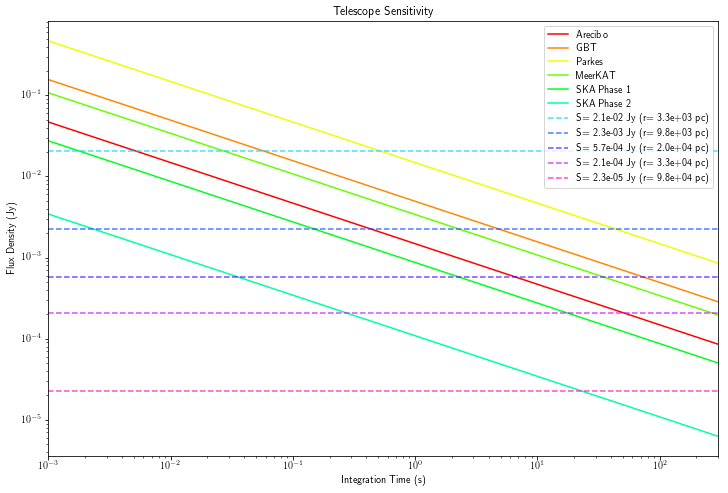

In [124]:
distParSec = 3.26 * np.array([1e3, 3e3, 6e3, 1e4, 3e4]) # distances in parsecs

cmap = plt.cm.hsv
colors = iter(cmap(np.linspace(0, 0.9, 6 + len(distParSec)))) # number of telescopes + number of fluxs

plt.loglog(tObs, areciboSMin, color=next(colors), label='Arecibo')
plt.loglog(tObs, gbtSMin, color=next(colors), label='GBT')
plt.loglog(tObs, parkesSMin, color=next(colors), label='Parkes')
plt.loglog(tObs, meerkatSMin, color=next(colors), label='MeerKAT')
plt.loglog(tObs, ska1SMin, color=next(colors), label='SKA Phase 1')
plt.loglog(tObs, ska2SMin, color=next(colors), label='SKA Phase 2')

for dVal in distParSec:
    fd = fluxDenJy(dVal * ly2m)
    plt.axhline(y=fd, xmin=0.0, xmax=1.0, color=next(colors), linestyle="--", alpha=0.7, \
                label='S= %.1e Jy (r= %.1e pc)'%(fd, dVal))

plt.ylabel('Flux Density (Jy)')
plt.xlabel('Integration Time (s)')
plt.xlim(10**minObsTime, 10**maxObsTime)
plt.title('Telescope Sensitivity')
plt.legend()

The plot above shows the sensitivty of various telescope (both single dish, and arrays) which can be used to detect RADAR signals as a function of integration time.

I have used the nominal bandwidth of 100 MHz and constant signal (i.e. duty cycle = 1) to generate this plot. In fact the bandwidth doesn't matter very much, it is more a question of the amount of search space covered in a SETI program. If an observational program is only looking in a narrow band, say 1 MHz, then the sensitivity of the search will be decreased by a factor of $\sqrt{100} = 10$ if the transmission signal is 100 MHz wide. An observational program which covers a large bandwidth and has the computational power to search over many bandwidths is preferred.

The duty cycle can be thought of as virtual. Assuming a RADAR signal goes on indefinately, even with a low duty cycle, sufficent $\Delta \tau_{\textrm{obs}}$ can be accumulated using a folding or gating search. This requires recording high time resolution spectra, and given enough computational power, a search can be preformed similar to pulsar searches.

Now, let us consider the current Breakthrough Listen observation strategy. A typical observation is 5 minutes of a target source (Source A), 5 minutes on a nearby secondary source (Source B1), back to Source A, then to a new secondary source (Source B2), back to Source a, and then finally to a third secondary source (Source B3). This strategy is used to mitigate human-made RFI.

Assuming an ideal case where Source A has a Arecibo-like RADAR, with a duty cycle $d_{\textrm{cycle}} = 1$, pointed directly at Earth, what is the maximum distance this source can be for a given telescope? That is, where is

$$S_{\textrm{min}} = S_{\nu}(r_{\textrm{max}})$$

Solving for $r_{\textrm{max}}$

$$r_{\textrm{max}} = \left( \frac{L_{\textrm{iso}, \nu} \cdot N_{\textrm{antenna}} \; \sqrt{d_{\textrm{cycle}} \; N_{\textrm{pol}} \; \Delta \tau_{\textrm{obs}} \; \Delta \nu_{\textrm{obs}}}}{4 \pi \cdot \textrm{SEFD} \cdot \textrm{SNR}_\textrm{min}} \right)^{1/2}$$

In [125]:
maxtObs = 15. * 60. # maximum BL observation time on a target source, seconds
rMax = lambda SEFD, nAnt, nPol: np.sqrt(((lumIso/10e-26) * nAnt * np.sqrt(dutyCycle * 2. * maxtObs * nuObs))/ \
                                 (4. * np.pi * SEFD * snrMin)) # meters

print 'Maximum detectable distance, (t=%.1f s)'%(maxtObs) 
print '\tArecibo: %.1e ly'%(rMax(areciboSEFD, 1, 2) / ly2m)
print '\tGBT: %.1e ly'%(rMax(gbtSEFD, 1, 2) / ly2m)
print '\tParkes: %.1e ly'%(rMax(parkesSEFD, 1, 2) / ly2m)
print '\tMeerKAT: %.1e ly'%(rMax(meerkatSEFD, 64, 2) / ly2m)
print '\tSKA-1: %.1e ly'%(rMax(ska1SEFD, 250, 2) / ly2m)
print '\tSKA-2: %.1e ly'%(rMax(ska2SEFD, 2000, 2) / ly2m)

Maximum detectable distance, (t=900.0 s)
	Arecibo: 6.6e+04 ly
	GBT: 3.6e+04 ly
	Parkes: 2.1e+04 ly
	MeerKAT: 4.4e+04 ly
	SKA-1: 8.7e+04 ly
	SKA-2: 2.5e+05 ly


In [126]:
# hom many stars are in this volume?
# this is optimistic, what are the limitations?
# extension to broadband leakage